NOTE: I'd recommend you get started with this only after going through Resource no. 1 (see tutorial/resources), which is an excellent foundation for computational chemistry. 

In this exercise we want to recreate Fig. 3a of Kandala et al. ***Nature 549,242–246***, reproduced below
<div>
<img src="kandala.png" width="500"/>
</div>

This is one of the first quantum chemistry algorithms implemented on a real quantum computer. The algorithm used for this is the Variational Quantum Eigensolver (VQE) algorithm.  They obtain the ground state energy of the $H_2$ molecule as a function of the interatomic distance - this is called a potential energy curve, and in general (that is, for a more complicated geometry) a **potential energy surface (PES)**, and is one of the fundamental problems of quantum chemistry - that we eventually plan to run on our quantum computer in Eindhoven. 

Why are such ground state problems interesting? They can be used to predict reaction rates of molecules, as well as to obtain the geometry and structure of molecules. This is of great significance towards, for instance, drug discovery and pharmacy applications. 
From a more 'fundamental physics' PoV, the computational techniques developed for this purpose can be directly applied to study quantum many-body systems (superconductors, Mott insulators, topological insulators etc.).

Our goal here is to run a similar VQE algorithm with a simulation of a quantum computer. The approach we use is further detailed in Sec. VIIA.1. of ***Rev. Mod. Phys. 92, 015003***. 

I use various Python libraries for the functionality, and it could be interesting for you to go through the tutorials/documentation (especially for qutip and openfermion) to see what additional functionality exists and can be incorporated. I link the tutorial websites below, and the documentation can be found with google:) Important also is the installation of these libraries, let me know in case you have any trouble installing them. 

A rundown of the important libraries (along with links to tutorials): 
1. 'qutip' is useful to evaluate and construct the quantum circuit. https://qutip.org/qutip-tutorials/
2. 'openfermion' handles the classical computation aspect of quantum chemistry. For instance, we need a Hartree-Fock (HF) routine to obtain HF orbitals, and obtain an effective ground state (with a single Slater determinant), which we use as an initial guess for the VQE algorithm. https://quantumai.google/openfermion/tutorials/intro_to_openfermion 
3. 'openfermionpyscf' openfermion relies on the pyscf library that has long been established for quantum chemistry calculations on a classical computer. openfermionpyscf is a wrapper that allows openfermion to interface with pyscf. You will need to install both pyscf as well as this wrapper. 

Below we import the relevant libraries. We also import 'helper.py' that contains helper functions coded by me, that make the VQE implementation functional. This is needed as qutip does not have ALL the functionality needed especially for NISQ-era algorithms. 

In [16]:
import scipy 
import numpy as np
import qutip as qt 
import openfermion as of
import openfermionpyscf as scfwrap
import matplotlib.pyplot as plt 

from helper import conv, meas, vqerun

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
Let's take this step-by-step. To obtain the ground state energy of a molecular Hamiltonian with the VQE algorithm, the following steps are needed: 

1. (classical pre-routine 1) Obtain the molecular Hamiltonian in terms of the basis functions. 
2. (classical pre-routine 2) Obtain the molecular orbitals (MOs) as a linear combination of the basis functions, and the initial state that one needs to input to the quantum circuit using a Hartree-Fock calculation. 

(***NOTE***) The section 'Hierarchy of Linear Combinations in Quantum Chemistry', lecture 'Basis Sets part 1' timestap 23:35 (https://www.youtube.com/watch?v=Hk4YRb4okC4) is very useful to keep coming back to in case there is a confusion about all the different kinds of orbitals, linear combinations involved etc.)

3. With the initial state as the input to the quantum circuit, we run the quantum circuit and take multiple measurements, in order to measure the energy of the ground state (that is, the overlap $E_{gs}$ = $\bra{\Psi(\Theta)}H_{mol}\ket{\Psi(\Theta)}$, where $H_{mol}$ is the molecular Hamiltonian and $\Psi(\Theta)$ the parametrized wavefunction output of the quantum circuit, which we ideally want to be the ground state). 

4. Further, we measure the gradients (if using a gradient-based classical optimizer), and input both the gradients and measured energy into the classical optimizer, which is tasked with minimizing $E_{gs}$ as a function of $\Theta$, and tells us what the new parameters $\Theta '$ should be. We repeat this procedure until we reach convergence.

I shall elaborate on all these steps below, so no worries if you don't know what they mean.

Factors that can influence the performance of the quantum algorithm (and have been extensively studied): 

1. ***The choice of the initial state for the algorithm***: Usually, the closer the initial state is to the actual ground state, the better the performance of the quantum algorithm. However, this also usually translates into a greater computational cost for the classical computer. Running the Hartree-Fock algorithm to obtain the initial state is a nice compromise. 

2. ***The choice of the circuit ansatz***: this determines the optimization space. The larger the optimization space the more likely it is we converge to the true ground state, however this (in general) also implies a larger amount of quantum gates and/or variational parameters in the ansatz, which often makes the computation out of reach for NISQ-era quantum computers.

3. ***The choice of the fermion-to-qubit mapping***: The Jordan-Wigner mapping is the standard mapping, but there is a wide variety of mappings that have been discovered, each with their own unique features. For instance, one can construct mappings that reduce the amount of qubits needed for the problem, reduce the amount of measurements needed, etc. 

Some other factors (that one can eventually also look at) include: Choice of classical optimizer (gradient vs. gradient free methods), quantity to be measured etc. 

We start off by defining the quantum circuit, as the unitary coupled cluster singles-doubles (UCCSD) Ansatz for $H_2$ (we include the circuit, Fig. 11 of ***Rev. Mod. Phys. 92, 015003*** below). ![title](uccsdh2.png)
It is important to note that we only have one variable parameter in this circuit, $\theta$ in the $R_z$ gate, thus the input 'theta' to the 'uccsdh2' function below is just a number (in general, this will be a vector, consisting of all the variational parameters in the circuit).  


In [17]:
def uccsdh2(theta, draw = 0): #unitary coupled cluster ansatz
    circ = qt.qip.circuit.QubitCircuit(4, num_cbits = 4)
    circ.add_gate("RX", targets=[0], arg_value=np.pi/2)
    circ.add_gate("SNOT", targets=[3]) # Note that SNOT is equivalent to the Hadamard gate 
    circ.add_gate("SNOT", targets=[2])
    circ.add_gate("SNOT", targets=[1])
    circ.add_gate("CNOT", controls=0, targets=1)
    circ.add_gate("CNOT", controls=1, targets=2)
    circ.add_gate("CNOT", controls=2, targets=3)
    circ.add_gate("RZ", targets=[3], arg_value=2*theta)
    circ.add_gate("CNOT", controls=2, targets=3)
    circ.add_gate("CNOT", controls=1, targets=2)
    circ.add_gate("CNOT", controls=0, targets=1)
    circ.add_gate("RX", targets=[0], arg_value= -np.pi/2)
    circ.add_gate("SNOT", targets=[3])
    circ.add_gate("SNOT", targets=[2])
    circ.add_gate("SNOT", targets=[1])
    return circ

Now, we can start with the classical part of the calculation. VQE is (almost) always used with the second-quantization approach: here, this means that we project the electronic Hamiltonian onto a finite number of basis functions (in order to make the problem computationally tractable). So we start with steps 1 and 2, that is, the classical pre-routine.

In [18]:
mol_geometry = [('H',(0, 0, 0)), ('H', (0, 0, 1.2))] #specify the H_2 molecule with a bond length 1.2Å

# 'MolecularData' is an openfermion class designed to contain information about the molecule we wish to study.

mol_obj = of.chem.MolecularData(mol_geometry, basis='sto-3g', multiplicity=1, charge=0, description="1.2")

Note that defining the object itself does not do much. We also need to run calculations in order to get single-electron and double-electron integrals. This allows us to build the Hamiltonian in the STO-3G basis.
We do this below with the ***'run_pyscf'*** command, which calls the pyscf library for these integral calculations. This 'fills up' the MolecularData class with the integrals, which we then access with the ***'get_molecular_data'*** command.  

The 'run_scf' and 'run_fci' options carry out classical algorithms - the self-consistent field (also known as Hartree-Fock) method and the full CI method - to compute the ground state. We will later use these as a benchmark for the accuracy of our quantum algorithms. We also run a sample optimization to get $E_{gs}$ for a specific bond length 1.2Å. 

In [19]:
mol_obj = scfwrap.run_pyscf(mol_obj, run_scf=1, run_fci=1,
                         verbose=0) # returns a MolecularData class with relevant calculations included 

aux_obj = mol_obj.get_molecular_hamiltonian() #H2 hamiltonian, in the HF MO basis

# a side note: one should also keep track of the spin index
#Molecular orbitals 0 and 1 have the same spatial dependence, and 2 and 3 have the same.
#0 and 2 have same spin, 1 and 3 too.

mol_fermi = of.transforms.get_fermion_operator(aux_obj) #returns a FermionOperator type
#see https://quantumai.google/openfermion/tutorials/intro_to_openfermion for more details 

# Now that we have the molecular Hamiltonian in the appropriate (STO-3G) basis representation, it is also important 
# to map it to our quantum computer i.e. to the qubits 
# The Jordan-Wigner mapping is popular for this purpose

qubitham = of.transforms.jordan_wigner(mol_fermi) 

#right now H_2 has been initialized with a bond length of 1.2Å
hf, fci, vqe, bdist = [], [], [], []

#c = h2_molecule.canonical_orbitals, column 1 gives MO 1 (g), column 2 gives MO 2 (u).

theta1 = 0 # variational parameter 

#vqeh2 = qubitham.terms

coeffs = []
measurements = 100 # number of measurements
# Note that the number of measurements determines the accuracy of your result

funcpara = uccsdh2 #just the circuit ansatz as shown above

# see 'helper.py' for more details on the actual VQE implementation 

optimf = conv(funcpara, measurements, qubitham) 
thetaopt = scipy.optimize.minimize(optimf, [theta1], method='COBYLA')
print('The ground state energy at bond length 1.2 Angstrom:')
print(thetaopt.fun)
#for epsilon accuracy you need epsilon^(-2) measurements

The ground state energy at bond length 1.2 Angstrom:
-1.0611713954522186


So we now have the energy at a certain bond length. To compute the potential energy curve we need this energy at 
various different bond lengths (just means, putting the above code into a loop)

0.15999381441862243
0.15748213479836348
-0.5851497627081135
-0.6018037107656873
-0.9249258221663611
-0.9141497046270848
-1.0292341764972959
-1.0551597944706257
-1.1165353802254705
-1.1162860068695393
-1.1370648523852345
-1.1361894540659232
-1.1149342634762192
-1.1341476666770962
-1.104977807838574
-1.1205602812999886
-1.1127351648010542
-1.1011503302326187
-1.0795287418534307
-1.079192944969075
-1.0596209143196293
-1.0567407463052574
-1.0332829807153978
-1.0351862664342546
-1.0026483750612618
-1.0154682492882454
-0.9892140299560224
-0.9981493534714101
-0.9793534065742051
-0.9834727290331735
-0.9353718034854505
-0.9714266884583416
-0.9425612268952908
-0.9618169527925807
-0.9524014180914482
-0.9543388539987274
-0.941007228667901
-0.9486411121761857
-0.9398445456287338
-0.9443746811197424
-0.9396048520030591
-0.9412240336932622
-0.9385996686807506
-0.9389223859872746
-0.9276707050989168
-0.9372549530096291
-0.9180534014006375
-0.9360549199556063
-0.9415617479171399
-0.9351960308474738
-0.

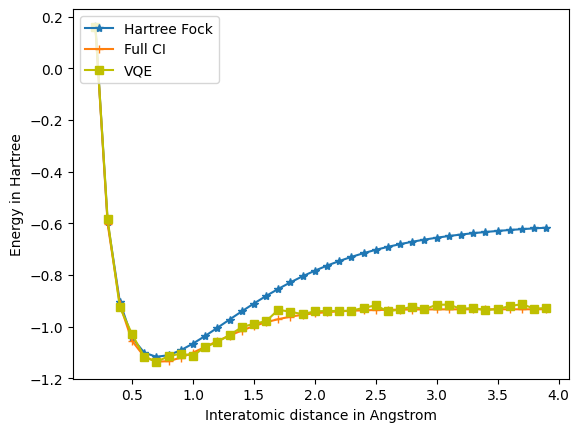

<Figure size 640x480 with 0 Axes>

In [20]:
for i in range(2, 40):
    length = 0.1*i
    bdist += [length]
    desc = str(round(length,2))
    geom = [('H', (0, 0, 0)), ('H', (0, 0, length))]
    mc = of.chem.MolecularData(geom, 'sto-3g', multiplicity=1, charge=0, description = desc)
    mol = scfwrap.run_pyscf(mc,
                         run_scf=1,
                         run_fci=1,
                         verbose=0)
    hf += [mol.hf_energy]
    fci += [mol.fci_energy]
    k1 = mol.get_molecular_hamiltonian()
    qubitham = of.transforms.jordan_wigner(of.transforms.get_fermion_operator(k1))
    optimf = conv(uccsdh2, measurements, qubitham)
    thetaopt = scipy.optimize.minimize(optimf, [theta1], method='COBYLA')
    print(thetaopt.fun)
    print(mol.fci_energy)
    vqe += [thetaopt.fun]
    #implement 'ideal' i.e. infinite measurements
    #implement pulse vqe
    #implement the different basis sets and symmetries
plt.figure(1)
plt.plot(bdist, hf,'*-', label = "Hartree Fock")
plt.plot(bdist, fci, '+-', label = "Full CI")
plt.plot(bdist, vqe, 's-y', label = "VQE")
plt.ylabel('Energy in Hartree')
plt.xlabel('Interatomic distance in Angstrom')
plt.legend(loc="upper left")
plt.figure(2)
#iter = np.linspace(1, thetaopt.nfev+1, thetaopt.nfev)
#plt.plot(iter, eniter)
#plt.ylabel('Energy in Hartree')
#plt.xlabel('Number of iterations')
plt.show()

So now we have reproduced the curve I showed in the beginning of the notebook (try increasing the number of measurements after each circuit evaluation if your plot does not converge)! 

It is interesting to note that VQE outputs the same solution as obtained by the full configuration interaction (full-CI) algorithm, which is a classical algorithm that outputs the exact result. 

While the result on the quantum computer (dating back to 2017) was impressive, $H_2$ is a system that people could simulate with classical computers quite easily. So this is a starting point, but in modern variational algorithms research we want to go further. 
That being said, this is a good starting point for future research and for your BEP. 

Further steps: 
1. It is worth playing around with the code -- for instance, how would you compute similar curves for larger molecules? See for instance fig. 3b of ***Nature 549,242–246*** for the LiH molecule. Section VIIB. of ***Rev. Mod. Phys. 92, 015003*** presents a nice example to implement the LiH calculation, you could modify the code above to try and get the LiH curves.

2. (optional) It is rather interesting to try out different fermion-to-qubit mappings. For instance the Bravyi-Kitaev mapping, so could be interesting to play around with the mappings. The openfermion library already has a few mappings implemented. 

3. (optional) The current implementation is with a gradient-free classical optimizer method. Can you try to use a gradient-descent algorithm (using the functionality from scipy)? 